In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy

from scipy.integrate import odeint, solve_ivp
from sympy import lambdify, Matrix, symbols, Symbol, Eq
from sympy.solvers.ode.systems import dsolve_system
from sympy import vector, solve
from typing import Tuple
from cycler import cycler
from collections import defaultdict

plt.style.use('style.mpl')

# Gaining intuition about linear pathway kinetics by simulation

We are curious how to describe pathways with effective enzyme kinetics. i.e. we imagine a linear pathway with some intermediary steps

$M_0 \leftrightarrow M_1 \leftrightarrow M_2 \leftrightarrow M_3$ 

each of which is catalyzed by an enzyme $E_i$ with MM kinetics. If those enzymes are irreversible then 

$\frac{d M_0}{d t} = -E_0 k_{cat,0} M_0 / (M_0 + K_{M,0})$

for the first pathway metabolite ($M_0$), presuming no other fluxes producing/consuming $M_0$.

In the irreversible system each $M_i$ has exactly one matching $K_{M,i}$ so we can normalize $m_i = M_i / K_{M,i}$ to simplify

$\frac{d M_0}{d t} = -E_0 k_{cat,0} m_0 / (m_0 + 1)$

We would like to represent the entire pathway as an effective MM enzyme with substrate $M_0$, product $M_k$, and kinetic parameters $K_M^*$, $k_{cat}^*$, and molar mass MW$^*$. What should the values of those parameters be as a function of the parameters of pathway enzymes? 

Below we set up a simulation to investigate these questions, first setting the mass-conservation terms for a 3 step pathway with linear kinetics. Then we modify the pathway to have irreversible MM kinetics and investigate changes to $K_M^*$, $k_{cat}^*$ as individual enzymes kinetics change. 

Some summary results:
* When enzyme kinetics are linear, effective pathway kinetics are also linear. 
* This is true even for reversible linear kinetics, i.e. non-negligible reverse rates at each step. 
* When kinetics are saturating, effective pathway kinetics are as well.
    * $k_{cat}^*$ is set by the minimum of pathway $k_{cat}$ values
    * $K_M^*$ appears to be set by rescaling $K_{M,0}$ to the new $k_{cat}$

So if we treat all enzymes as having the same kinetics, $k_{cat}^*$ $K_M^*$ simply equal those chosen values. If enzymes differ, e.g. if kinetic parameters are lognormally distributed, then estimating $k_{cat}^*$ becomes an extreme value problem and $K_M^*$ would be calculated from $k_{cat}^*$. 

In [2]:
# stoichiometric matrix -- metabolites on rows, reactions on columns
S = [
    [-1, 0, 0],  # R_0 converts 1 M_0 to 1 M_1
    [1, -1, 0],  # R_1 converts 1 M_1 to 1 M_2
    [0, 1, -1],  # R_3 converts 1 M_2 to 1 M_3
    [0, 0, 1],
]
S = np.array(S)

display(S)

array([[-1,  0,  0],
       [ 1, -1,  0],
       [ 0,  1, -1],
       [ 0,  0,  1]])

In [3]:
# Total enzyme abundances.
Es = E_0, E_1, E_2 = sympy.symbols("E_0 E_1 E_2") 

# Catalytic rates
kplus = kp_0, kp_1, kp_2 = sympy.symbols("kp_0 kp_1 kp_2")
kminus = km_0, km_1, km_2 = sympy.symbols("km_0 km_1 km_2")

# half-saturation constants, forwards and reverse
KMf = KMf_0, KMf_1, KMf_2 = sympy.symbols("KMf_0 KMf_1 KMf_2")
KMr = KMr_0, KMr_1, KMr_2 = sympy.symbols("KMr_0 KMr_1 KMr_2")

# Metabolite concentrations
Cs = C_0, C_1, C_2, C_3 = sympy.symbols("C_0 C_1 C_2 C_3") 

# initial concs are 0 unless otherwise stated
# in practice will fix C_0 at some value in the dynamical equations
initial_concentrations = defaultdict(float)

# time 
t = sympy.symbols("t")

# Arrays for symbolic math
Es_array = np.array(Es) 
Cs_array = np.array(Cs)
kp_array = np.array(kplus)
km_array = np.array(kminus)
KMf_array = np.array(KMf)
KMr_array = np.array(KMr)
subs_array = np.array(Cs[:-1])
prods_array = np.array(Cs[1:])

# Concentration dynamics for linear, reversible enzyme kinetics
dCdt_lin = (S*kp_array*subs_array*Es_array).sum(axis=1)-(S*km_array*prods_array*Es_array).sum(axis=1)

# Show the equations in a nice format.
dy_dt = sympy.Matrix(dCdt_lin, ndmin=1)
symbolic_dy_dt = sympy.Matrix([sympy.Derivative(symb, t) for symb in Cs], ndmin=1)
display(sympy.Eq(symbolic_dy_dt, dy_dt))

Eq(Matrix([
[Derivative(C_0, t)],
[Derivative(C_1, t)],
[Derivative(C_2, t)],
[Derivative(C_3, t)]]), Matrix([
[                             -C_0*E_0*kp_0 + C_1*E_0*km_0],
[C_0*E_0*kp_0 - C_1*E_0*km_0 - C_1*E_1*kp_1 + C_2*E_1*km_1],
[C_1*E_1*kp_1 - C_2*E_1*km_1 - C_2*E_2*kp_2 + C_3*E_2*km_2],
[                              C_2*E_2*kp_2 - C_3*E_2*km_2]]))

In [4]:
# Irreversible limit where k- = 0 for all reactions. 
subs_irr = dict(E_0=1, E_1=1, E_2=1, 
                kp_0=1, kp_1=1, kp_2=1,
                km_0=0, km_1=0, km_2=0)
irreversible_dynamics = Matrix(dy_dt, ndim=1).subs(subs_irr)

# Reversible dynamics -- each step has k- = 0.1*k+
subs_rev = subs_irr.copy()
subs_rev.update(dict(km_0=0.1, km_1=0.1, km_2=0.1))
reversible_dynamics = Matrix(dy_dt, ndim=1).subs(subs_rev)

print('irreversible_dynamics')
display(irreversible_dynamics)

print('reversible_dynamics')
display(reversible_dynamics)

irreversible_dynamics


Matrix([
[     -C_0],
[C_0 - C_1],
[C_1 - C_2],
[      C_2]])

reversible_dynamics


Matrix([
[         -C_0 + 0.1*C_1],
[C_0 - 1.1*C_1 + 0.1*C_2],
[C_1 - 1.1*C_2 + 0.1*C_3],
[          C_2 - 0.1*C_3]])

In [5]:
# Helper to do the translation from sympy to odeint
def integrate(ys: list, 
              dy_dt: sympy.Matrix,
              initial_concs: dict,
              max_t: float) -> Tuple[np.ndarray, np.ndarray]:
    J_func = sympy.lambdify((ys, t), dy_dt)
    J2_func = lambda y, t: J_func(y, t).flatten()

    tout = np.linspace(0, max_t, 10000)
    y_init = [initial_concs[symb] for symb in ys]
    
    y_odeint = odeint(J2_func, y_init, tout)
    return tout, y_odeint

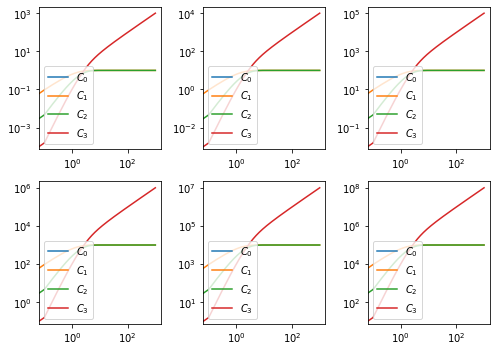

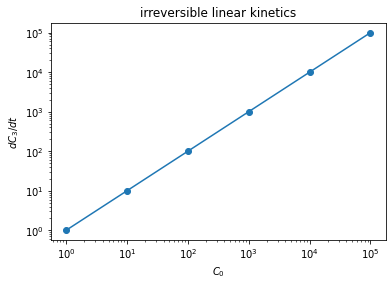

In [6]:
# Simulate the dynamics of the irreversible pathway.
fig, axs = plt.subplots(2, 3, figsize=(7, 5))
flat_axs = axs.flatten()

c_0_conc = np.logspace(0, 5, 6)
out_rates = []
my_dynamics = irreversible_dynamics
for c, ax in zip(c_0_conc, flat_axs):
    # Fix the concentration of C_0 to c.
    tout, y_odeint = integrate(Cs, my_dynamics.subs({C_0: c}),
                               initial_concentrations, 1000)
    
    # Get concentrations near the end of the simulation to treat as steady state.
    cvals_ss = dict(zip(Cs, y_odeint[-5, :]))
    # Calcualte the rate of production of the product, C_3.
    prod_rate = my_dynamics[-1].subs(cvals_ss)
    out_rates.append(prod_rate)

    plt.sca(ax)
    plt.loglog(tout, y_odeint)
    plt.legend([f"${sympy.latex(symb)}$" for symb in Cs])

plt.tight_layout()
plt.show()

plt.figure()
plt.loglog(c_0_conc, out_rates, "o-")
plt.title('irreversible linear kinetics')
plt.xlabel("$C_0$")
plt.ylabel("$dC_3/dt$")
plt.show()

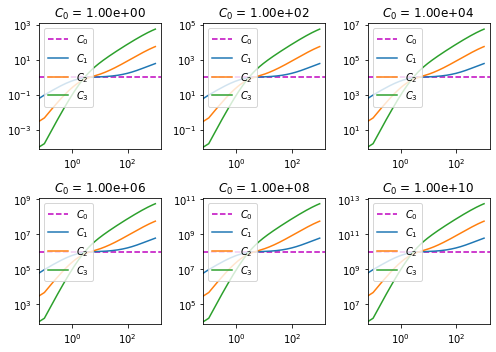

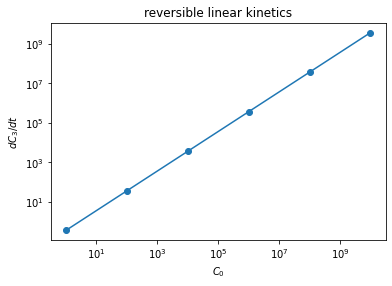

In [7]:
# Simulate the dynamics of the irreversible pathway.
fig, axs = plt.subplots(2, 3, figsize=(7, 5))
flat_axs = axs.flatten()

c_0_conc = np.logspace(0, 10, 6)
out_rates = []
my_dynamics = reversible_dynamics
for c, ax in zip(c_0_conc, flat_axs):
    # Fix the concentration of C_0 to c.
    tout, y_odeint = integrate(Cs, my_dynamics.subs({C_0: c}),
                               initial_concentrations, 1000)
    
    # Get concentrations near the end of the simulation to treat as steady state.
    cvals_ss = dict(zip(Cs, y_odeint[-5, :]))
    # Calcualte the rate of production of the product, C_3.
    prod_rate = my_dynamics[-1].subs(cvals_ss)
    out_rates.append(prod_rate)

    plt.sca(ax)
    plt.axhline(c, linestyle="--", color="m")
    plt.loglog(tout, y_odeint[:,1:])
    #idxs = np.arange(950, 1000, 10)
    #plt.scatter(tout[idxs], y_odeint[:,-1][idxs], color="k")
    plt.legend([f"${sympy.latex(symb)}$" for symb in Cs])
    plt.title("$C_0$ = {:.2e}".format(c))

plt.tight_layout()
plt.show()

plt.figure()
plt.loglog(c_0_conc, out_rates, "o-")
plt.title('reversible linear kinetics')
plt.xlabel("$C_0$")
plt.ylabel("$dC_3/dt$")
plt.show()

In [8]:
# Concentration dynamics for a system with saturation
sub_sat = (subs_array+KMf_array)
prod_sat = (prods_array+KMr_array)
dCdt_sat = (S*kp_array*subs_array*Es_array/sub_sat).sum(axis=1)-(S*km_array*prods_array*Es_array/prod_sat).sum(axis=1)
dy_dt = sympy.Matrix(dCdt_sat, ndmin=1)
print('full reversible saturating dynamics')
display(dy_dt)

# Considering the case where all pathway steps are irreversible, and have the
# same kinetic parameters. 
subs_irr = dict(S_0=0, S_1=0, S_2=0, S_3=0,
                E_0=1, E_1=1, E_2=1, 
                kp_0=1, kp_1=1, kp_2=1,
                km_0=0, km_1=0, km_2=0,
                KMf_0=1, KMf_1=1, KMf_2=1)
irreversible_dynamics = Matrix(dy_dt, ndim=1).subs(subs_irr)

print('irreversible_dynamics')
display(irreversible_dynamics)


full reversible saturating dynamics


Matrix([
[                                                         -C_0*E_0*kp_0/(C_0 + KMf_0) + C_1*E_0*km_0/(C_1 + KMr_0)],
[C_0*E_0*kp_0/(C_0 + KMf_0) - C_1*E_0*km_0/(C_1 + KMr_0) - C_1*E_1*kp_1/(C_1 + KMf_1) + C_2*E_1*km_1/(C_2 + KMr_1)],
[C_1*E_1*kp_1/(C_1 + KMf_1) - C_2*E_1*km_1/(C_2 + KMr_1) - C_2*E_2*kp_2/(C_2 + KMf_2) + C_3*E_2*km_2/(C_3 + KMr_2)],
[                                                          C_2*E_2*kp_2/(C_2 + KMf_2) - C_3*E_2*km_2/(C_3 + KMr_2)]])

irreversible_dynamics


Matrix([
[               -C_0/(C_0 + 1)],
[C_0/(C_0 + 1) - C_1/(C_1 + 1)],
[C_1/(C_1 + 1) - C_2/(C_2 + 1)],
[                C_2/(C_2 + 1)]])

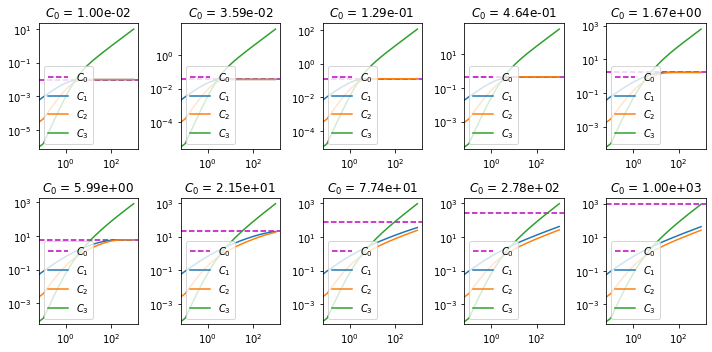

In [9]:
# Simulate the dynamics of the irreversible pathway.
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
flat_axs = axs.flatten()

c_0_conc = np.logspace(-2, 3, 10)
out_rates = []
my_dynamics = irreversible_dynamics
for c, ax in zip(c_0_conc, flat_axs):
    # Fix the concentration of C_0 to c.
    tout, y_odeint = integrate(Cs, my_dynamics.subs({C_0: c}),
                               initial_concentrations, 1000)
    
    # Get concentrations near the end of the simulation to treat as steady state.
    cvals_ss = dict(zip(Cs, y_odeint[-5, :]))
    # Calcualte the rate of production of the product, C_3.
    prod_rate = my_dynamics[-1].subs(cvals_ss)
    out_rates.append(prod_rate)

    plt.sca(ax)
    plt.axhline(c, linestyle="--", color="m")
    plt.loglog(tout, y_odeint[:,1:])
    #idxs = np.arange(950, 1000, 10)
    #plt.scatter(tout[idxs], y_odeint[:,-1][idxs], color="k")
    plt.legend([f"${sympy.latex(symb)}$" for symb in Cs])
    plt.title("$C_0$ = {:.2e}".format(c))

plt.tight_layout()
plt.show()

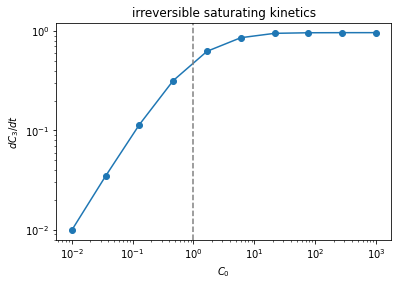

In [10]:
# Pathway has a max rate of 1.0 and a KM of 1.0 line each step.
plt.figure()
plt.loglog(c_0_conc, out_rates, "o-")
plt.axvline(1, linestyle="--", color="grey")
plt.title('irreversible saturating kinetics')
plt.xlabel("$C_0$")
plt.ylabel("$dC_3/dt$")
plt.show()

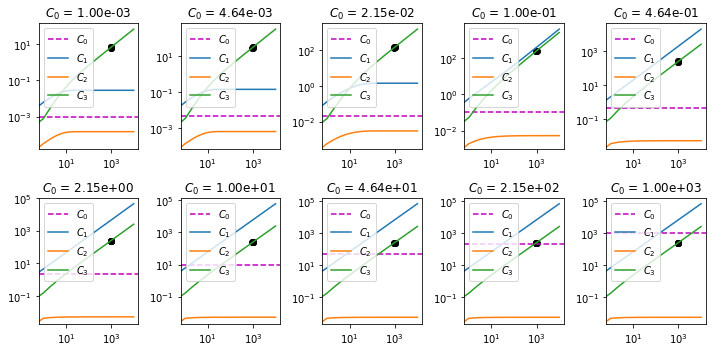

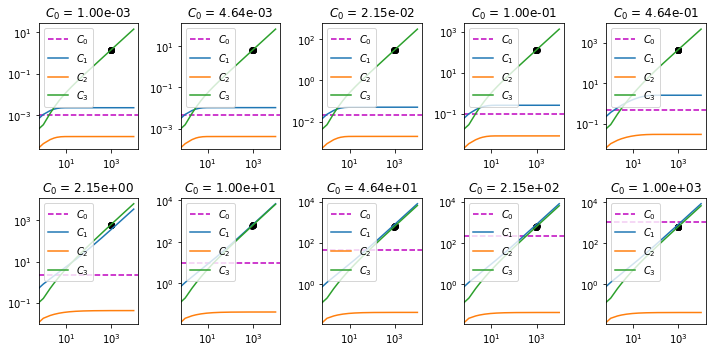

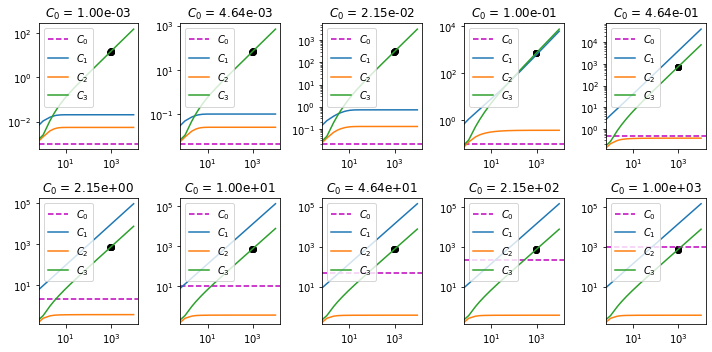

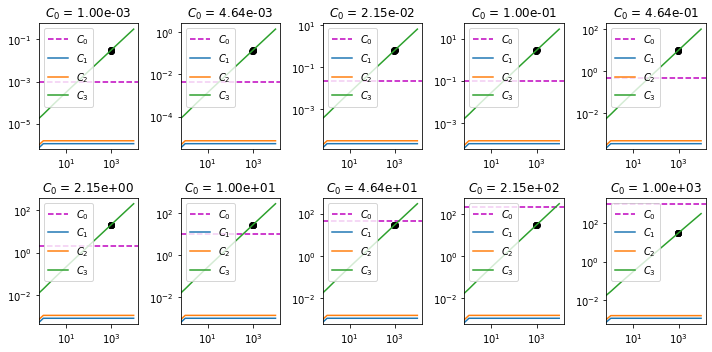

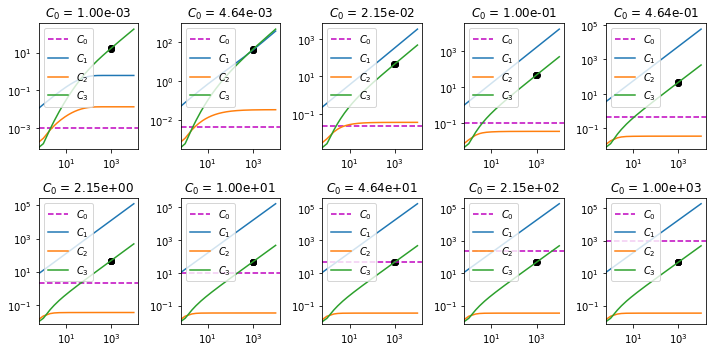

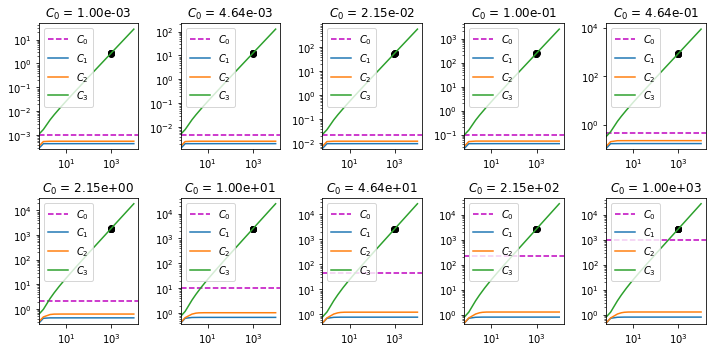

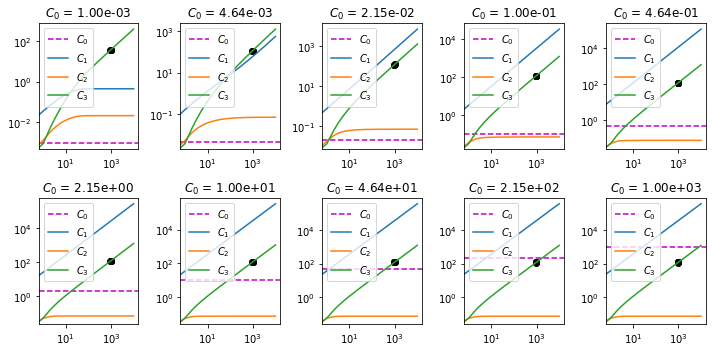

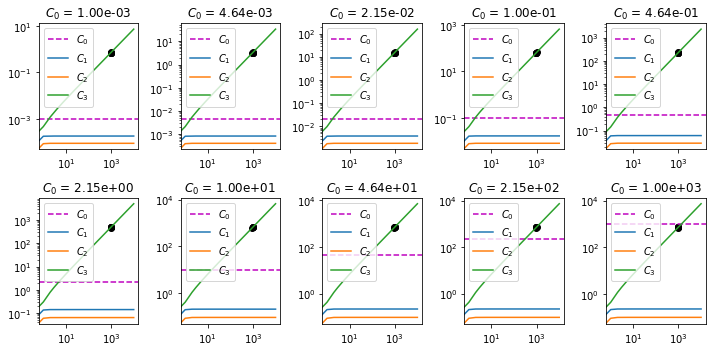

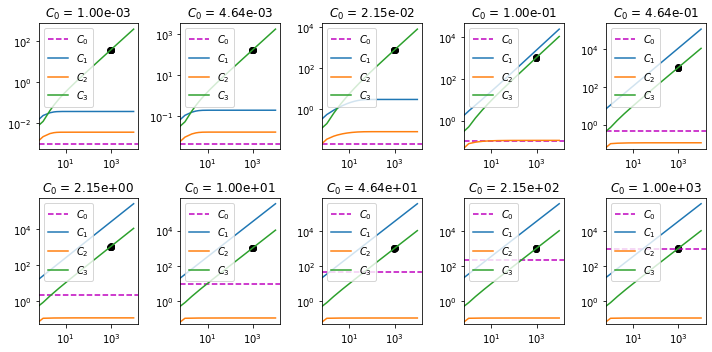

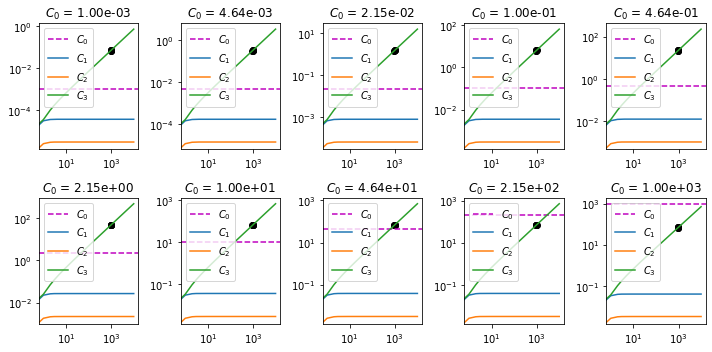

In [11]:
# Now we will sample forward kcat values from a lognormal distribution and
# simulate as a function of C_0 to see what pathway kcat looks like. 

# Make this reproducible randomization
np.random.seed(1234)

c_0_conc = np.logspace(-3, 3, 10)
sampled_kps = np.zeros((10, 3))
out_rates = np.zeros((10, 10))

for i in range(10):
    # Randomize the catalytic rates of each step, lognormal dist.
    rand_kps = np.random.lognormal(mean=1, sigma=2, size=3)
    sampled_kps[i, :] = rand_kps
    my_subs = subs_irr.copy()
    my_subs.update(dict(kp_0=rand_kps[0], kp_1=rand_kps[1], kp_2=rand_kps[2]))
    my_dynamics = Matrix(dy_dt, ndim=1).subs(my_subs)

    fig, axs = plt.subplots(2, 5, figsize=(10, 5))
    flat_axs = axs.flatten()
    for j, (c, ax) in enumerate(zip(c_0_conc, flat_axs)):
        # Fix the concentration of C_0 to c.
        tout, y_odeint = integrate(Cs, my_dynamics.subs({C_0: c}),
                                   initial_concentrations, 10000)
        
        # Get concentrations near the end of the simulation to treat as steady state.
        cvals_ss = dict(zip(Cs, y_odeint[-2, :]))
        # Calcualte the rate of production of the product, C_3.
        prod_rate = my_dynamics[-1].subs(cvals_ss)
        out_rates[i, j] = prod_rate

        plt.sca(ax)
        plt.axhline(c, linestyle="--", color="m")
        plt.loglog(tout, y_odeint[:,1:])
        idxs = np.arange(950, 1000, 10)
        plt.scatter(tout[idxs], y_odeint[:,-1][idxs], color="k")
        plt.legend([f"${sympy.latex(symb)}$" for symb in Cs])
        plt.title("$C_0$ = {:.2e}".format(c))
        
    plt.tight_layout()
    plt.show()

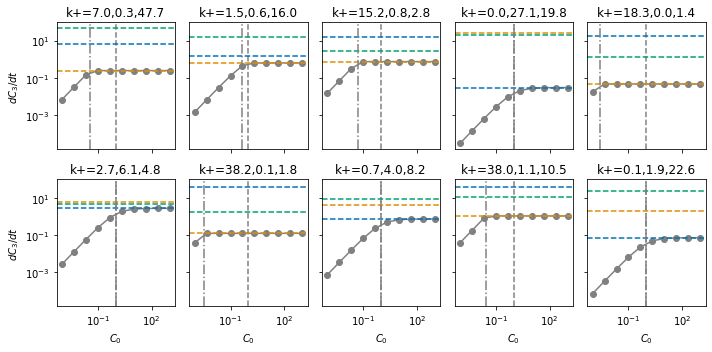

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5), sharex=True, sharey=True)
flat_axs = axs.flatten()

pal = sns.color_palette("colorblind", 3)
for i in range(10):
    plt.sca(flat_axs[i])
    plt.loglog(c_0_conc, out_rates[i, :], "o-", color='grey')

    plt.axvline(1, ls='--', color='grey')    
    for j in range(3):
        plt.axhline(sampled_kps[i,j], ls='--', color=pal[j])

    min_kp = np.min(sampled_kps[i, :])
    rescaled_KM = 1*min_kp/sampled_kps[i, 0] 
    plt.axvline(rescaled_KM, ls='-.', color='grey')

    plt.title("k+={:.1f},{:.1f},{:.1f}".format(*sampled_kps[i, :]))

for a in axs[1,:]:
    plt.sca(a)
    plt.xlabel("$C_0$")

for a in axs[:,0]:
    plt.sca(a)
    plt.ylabel("$d C_3 / dt$")

plt.tight_layout()
plt.show()